# Toxic Comments
-[Rishit Dagli](rishitdagli.ml)

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

##### And a few `Keras` imports too

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

### Lets load the data with `pandas`

In [3]:
train = pd.read_csv('Toxic comments/train.csv')
test = pd.read_csv('Toxic comments/test.csv')

### Some preprocessing

Lets view first some values to get an idea about the data

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Nows lets see if we have any null values in the dataset

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
test.isnull().any()

Unnamed: 0       False
id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Boo-yah no null values, you are saved of the procedure

Specify the classes and your `y` and `sentences`

In [7]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[classes].values
sentences_train = train["comment_text"]
sentences_test = test["comment_text"]

Lets define a few hyperparameters, you will understand what these mean later

In [16]:
max_words = 20000
max_features = 20000
maxlen = 200
embed_size = 128
batch_size = 32
epochs = 5

What next, Now we tokenize the words using some `TensorFlow` functions which make it very easy

Understand tokenizing as saying

Hi = 1

Are = 2

How = 3

in sentence Hi, How Are you?
if max_len is 3

I have inetntionally included `,`

In [9]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(sentences_train))
tokenized_train = tokenizer.texts_to_sequences(sentences_train)
tokenized_test = tokenizer.texts_to_sequences(sentences_test)

You could even look up the occurrence and the index of each words in the dictionary:

In [10]:
tokenizer.word_counts

OrderedDict([('explanation', 1771),
             ('why', 17818),
             ('the', 496540),
             ('edits', 9957),
             ('made', 9678),
             ('under', 7001),
             ('my', 45619),
             ('username', 1823),
             ('hardcore', 166),
             ('metallica', 35),
             ('fan', 1025),
             ('were', 15421),
             ('reverted', 3902),
             ('they', 27318),
             ("weren't", 424),
             ('vandalisms', 38),
             ('just', 27806),
             ('closure', 88),
             ('on', 89968),
             ('some', 22586),
             ('gas', 331),
             ('after', 8490),
             ('i', 204397),
             ('voted', 302),
             ('at', 39545),
             ('new', 10665),
             ('york', 912),
             ('dolls', 24),
             ('fac', 321),
             ('and', 224192),
             ('please', 29780),
             ("don't", 22917),
             ('remove', 5140),
          

Lets see indexes of 20000  most common words

In [11]:
tokenizer.word_index

{'911': 13378,
 "lets'": 166792,
 'appaloosa': 20872,
 'ahalya': 207794,
 'gunna': 23263,
 'zeredy': 133565,
 'nekokatsun': 203382,
 'thermonuclear': 63295,
 'xanthi': 58150,
 'debora': 163421,
 'settling': 17823,
 'நாம்': 79256,
 'apreciable': 190238,
 'parliment': 59392,
 'mooved': 144764,
 'matrys': 39690,
 'fapped': 198754,
 'yell': 12376,
 '3bcfrsh': 91674,
 'fimus': 77507,
 'delteit': 99323,
 'sportscenter': 172187,
 'waterhouse': 78240,
 'advertising': 1330,
 "almodóvar's": 188699,
 'mayuko': 115071,
 'rogvolod': 128999,
 '1880': 13690,
 'distancing': 46246,
 "royce's": 59480,
 'carvey': 87850,
 'ликвидации': 149550,
 'mewulwe': 62028,
 'yugan': 173279,
 'thefutoncritic': 183880,
 'troublemakers': 40856,
 'tigay': 164447,
 'inforcement': 147048,
 'clade': 20530,
 'philo': 25447,
 'fanatac': 185650,
 '4824429': 148659,
 'wahat': 172841,
 'atabegs': 158184,
 "highinbc's": 121585,
 "kitman's": 96550,
 'anticommunist': 99210,
 'enmascarado': 81093,
 'zoopnfunk': 123608,
 'wikiprojek

padding helps you to create all data points of same size as your sentences are of different lengths, it just attaches 0

In [12]:
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

A cool graph to visualize this

In [13]:
totalNumWords = [len(one_comment) for one_comment in tokenized_train]

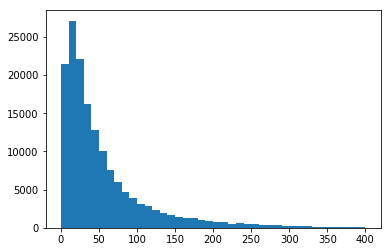

In [14]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

### Finally! Model

Lets create the model now!

In [17]:
model = tf.keras.Sequential([
    Input(shape=(maxlen, )),
    Embedding(max_features, embed_size),
    
    # Return_sequences=true, why? it's LSTM dude
    LSTM(60, return_sequences=True, name='lstm_layer'),
    
    # What solves overfitting
    # Droputs!!!
    Dropout(0.1),
    
    # When things become too big
    GlobalMaxPool1D(),
    
    # Dense is used most commonly and we did not use it yet :(
    Dense(50, activation="relu"),
    
    Dropout(0.1),
    Dense(6, activation="sigmoid")
])

In [18]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [19]:
history = model.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 242s 2ms/sample - loss: 0.0669 - accuracy: 0.9780 - val_loss: 0.0494 - val_accuracy: 0.9816
Epoch 2/5
143613/143613 [==============================] - 239s 2ms/sample - loss: 0.0447 - accuracy: 0.9832 - val_loss: 0.0475 - val_accuracy: 0.9823
Epoch 3/5
143613/143613 [==============================] - 238s 2ms/sample - loss: 0.0391 - accuracy: 0.9846 - val_loss: 0.0466 - val_accuracy: 0.9825
Epoch 4/5
143613/143613 [==============================] - 244s 2ms/sample - loss: 0.0339 - accuracy: 0.9866 - val_loss: 0.0491 - val_accuracy: 0.9826
Epoch 5/5
143613/143613 [==============================] - 240s 2ms/sample - loss: 0.0297 - accuracy: 0.9880 - val_loss: 0.0535 - val_accuracy: 0.9815


About our model in short

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
dropout (Dropout)            (None, 200, 60)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

### Some plots

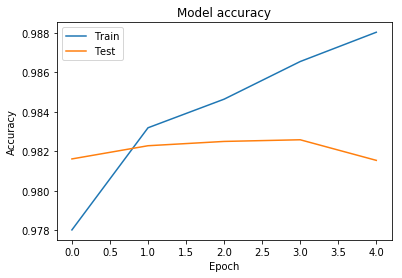

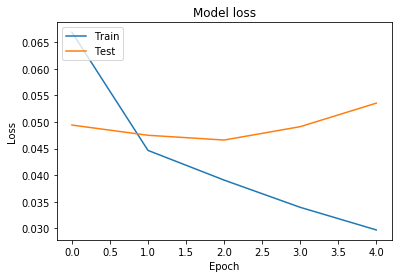

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Conclusion